Classification with logistic regession on the balanced dataset split by donors.
 - This is a baseline to assess performance of more complex models. 
 - Here here is no mitigation of batch effects; next iteration can consider a binning strategy.
 - Overall accuracy is ~0.89.

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
from schelp.utils.config import load_config
from rich import print as rprint
import pandas as pd
from schelp.utils.data import donor_split


import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


paths = load_config(dataset_key="init")


def load_dataset_balance(paths, seed=0):
    data_dir = str(paths["data"])
    adata_ = sc.read_h5ad(
        str(paths["data"]) + "/Human-Brain/balanced_SEAAD_MTG_RNAseq_Singleome_final-nuclei.2024-06-18.h5ad"
    )
    adata_.obs["celltype"] = adata_.obs["Supertype"]
    adata_.obs["batch"] = adata_.obs["Donor ID"]

    num_types = adata_.obs["celltype"].unique().size
    id2type = dict(enumerate(adata_.obs["celltype"].cat.categories))
    celltypes = adata_.obs["celltype"].unique()
    celltype_id_labels = adata_.obs["celltype"].astype("category").cat.codes.values
    adata_.obs["celltype_id"] = celltype_id_labels
    adata_.obs["batch_id"] = adata_.obs["batch"].cat.codes.values
    adata_.var["gene_name"] = adata_.var.index.tolist()

    # get high variance genes
    sc.pp.highly_variable_genes(adata_, n_top_genes=4000, flavor="cell_ranger", batch_key="batch")
    adata_ = adata_[:, adata_.var["highly_variable"]]
    # adata_ = sc.pp.subsample(adata_, fraction=0.1, copy=True, random_state=seed)
    n_cells = adata_.shape[0]

    # split the data into train and test
    # train_ind, test_ind = train_test_split(range(n_cells), test_size=0.2, random_state=seed)
    train_ind, test_ind = donor_split(obs=adata_.obs, donor_frac_pergroup=0.15)
    adata = adata_[train_ind].to_memory()
    adata_test = adata_[test_ind].to_memory()

    del adata_
    print(f"There are {adata.shape[0]} cells in the reference set")
    print(f"There are {adata_test.shape[0]} cells in the query set")

    return adata, adata_test, celltypes, id2type

In [2]:
# get the data splits
adata, adata_test, celltypes, id2type = load_dataset_balance(paths=paths, seed=0)

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_supertype_entropy = df.groupby("Donor ID")["Supertype"].apply(entropy).sort_values(ascending=False).to_frame()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_.groupby("Overall AD neuropathological Change")[df_.columns]
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:51: FutureWarning: The default of observed=Fals

High supertype entropy donors make up 15.18% of total cells
Train set: 84.82%
Test set: 15.18%
There are 117906 cells in the reference set
There are 21094 cells in the query set


In [3]:
# pipeline for logistic regression classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# split the data into train and test
X_train = adata.X.A
y_train = adata.obs["celltype_id"]
X_test = adata_test.X.A
y_test = adata_test.obs["celltype_id"]

# create a pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression())])

# fit the pipeline
pipe.fit(X_train, y_train)

# predict the test set
y_pred = pipe.predict(X_test)

# print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall test accuracy: {accuracy:0.3f}")

Overall test accuracy: 0.885


In [4]:
# rprint(classification_report(y_test, y_pred, target_names=celltypes))
report = classification_report(y_test, y_pred, target_names=celltypes, output_dict=True)
df = pd.DataFrame(report).transpose()

# round entries to 3 decimal places
df = pd.DataFrame(report).transpose()
display(df.tail(3))

# display full dataframe
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# reorder rows to match the order of celltypes
df = df.reindex(celltypes.categories.tolist())


# color any values less than 0.5
def color_negative_red(val):
    color = "#ff9999" if val < 0.5 else "black"
    return "color: %s" % color


display(df.round(3).style.map(color_negative_red))

,precision,recall,f1-score,support
accuracy,0.884517,0.884517,0.884517,0.884517
macro avg,0.886795,0.881632,0.881960,21094.000000
weighted avg,0.887941,0.884517,0.884695,21094.000000


,precision,recall,f1-score,support
Astro_1,0.822000,0.818000,0.820000,203.000000
Astro_2,0.849000,0.869000,0.859000,168.000000
Astro_3,0.873000,0.878000,0.875000,156.000000
Astro_4,0.968000,0.987000,0.978000,155.000000
Astro_5,0.966000,0.973000,0.969000,146.000000
Astro_6-SEAAD,0.993000,0.979000,0.986000,144.000000
Chandelier_1,0.534000,0.539000,0.537000,115.000000
Chandelier_2,0.870000,0.919000,0.894000,160.000000
Endo_1,0.959000,0.922000,0.940000,179.000000
Endo_2,0.934000,0.941000,0.938000,136.000000


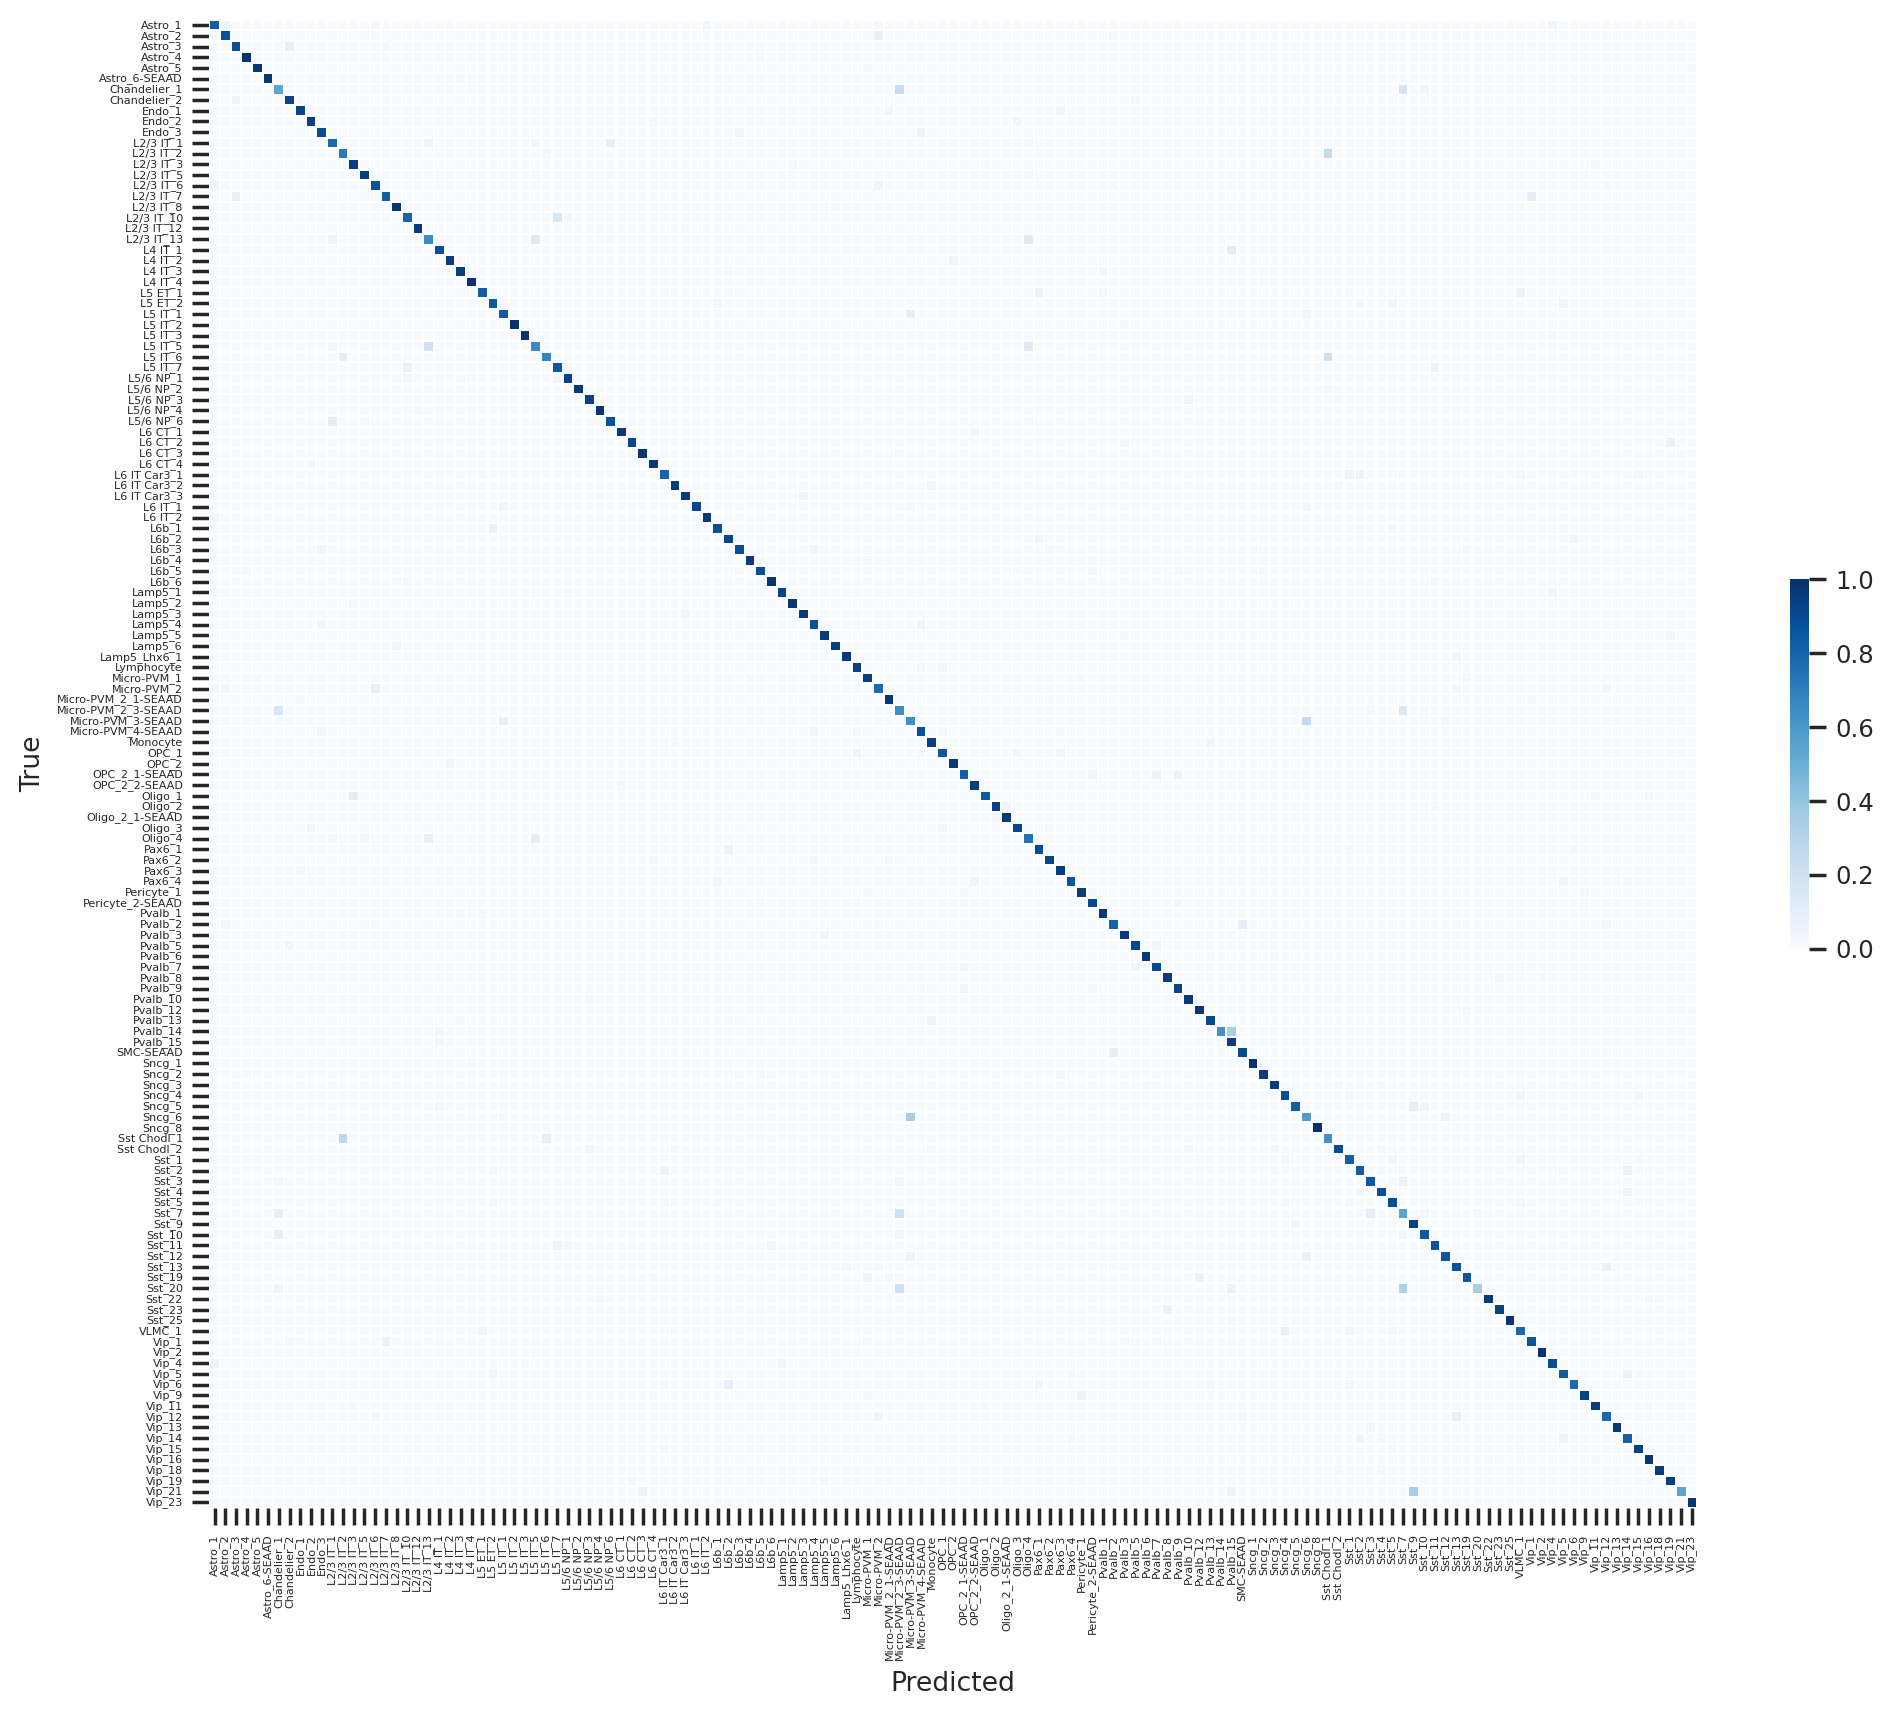

In [5]:
cm = confusion_matrix(y_test.values, y_pred, normalize="true")
cm = pd.DataFrame(cm, index=celltypes[: cm.shape[0]], columns=celltypes[: cm.shape[1]])

ordered_names = adata.obs["Supertype"].cat.categories.tolist()
values = np.zeros((len(ordered_names), len(ordered_names))) * np.nan

df = pd.DataFrame(values, index=ordered_names, columns=ordered_names)
# fill in available values in cm
for col_name in cm.columns:
    for row_name in cm.index:
        df.loc[row_name, col_name] = cm[col_name][row_name]

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    df,
    cmap="Blues",
    annot=False,
    fmt=".2f",
    annot_kws={"size": 5},
    vmin=0,
    vmax=1,
    ax=ax,
    linewidths=0.1,
    square=True,
    cbar_kws={"shrink": 0.2},
    xticklabels=1,
    yticklabels=1,
)
ax.set(xlabel="Predicted", ylabel="True")
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.show()